## PCA on Census, 

plotting the first to PCs as a scatter, and coloring them by the DSD level poverty label to observe distribution

In [42]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import geopandas as gpd
#from thefuzz import process
#from thefuzz import fuzz
import matplotlib.pyplot as plt

# DSD level poverty headcount index got from the department of census and statistics report
dsd_data = pd.read_csv('/lirneasia/data/sei_mapping/processed/dsd_headcount_index.csv')
dsd_data = dsd_data[['dsd_name', 'code_7', 'headcount_index']].copy()
# Sri lanka Shapefile

data_shapefile = gpd.read_file("/lirneasia/data/sei_mapping/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")
# Read census data

census_data = pd.read_csv('/lirneasia/data/sei_mapping/raw/census_features.csv')

In [41]:
dsd_data

,dsd_name,code_7,headcount_index
0,Hali Ela,8124120,8.91
1,Hali Ela,8124015,8.91
2,Hali Ela,8124020,8.91
3,Hali Ela,8124025,8.91
4,Hali Ela,8124030,8.91
...,...,...,...
14017,Dickwella,3248210,8.52
14018,Dickwella,3248230,8.52
14019,Dickwella,3248030,8.52
14020,Dickwella,3248225,8.52


In [44]:
census_data.fillna(0, inplace = True)
merged = census_data.merge(data_shapefile, left_on=census_data.gnd_id, right_on='code_7', how='inner')

merged = merged.drop(columns=['dsd_name'])
merged = merged.merge(dsd_data, left_on=merged.gnd_id, right_on='code_7', how='inner')

X = merged.drop(columns=['prov_name', 'dist_name', 'dsd_name', 'gnd_name', 'geometry', 'code_7', 'headcount_index'])

X.set_index('gnd_id', inplace=True)

y = merged.set_index('gnd_id')[['dsd_name', 'headcount_index']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


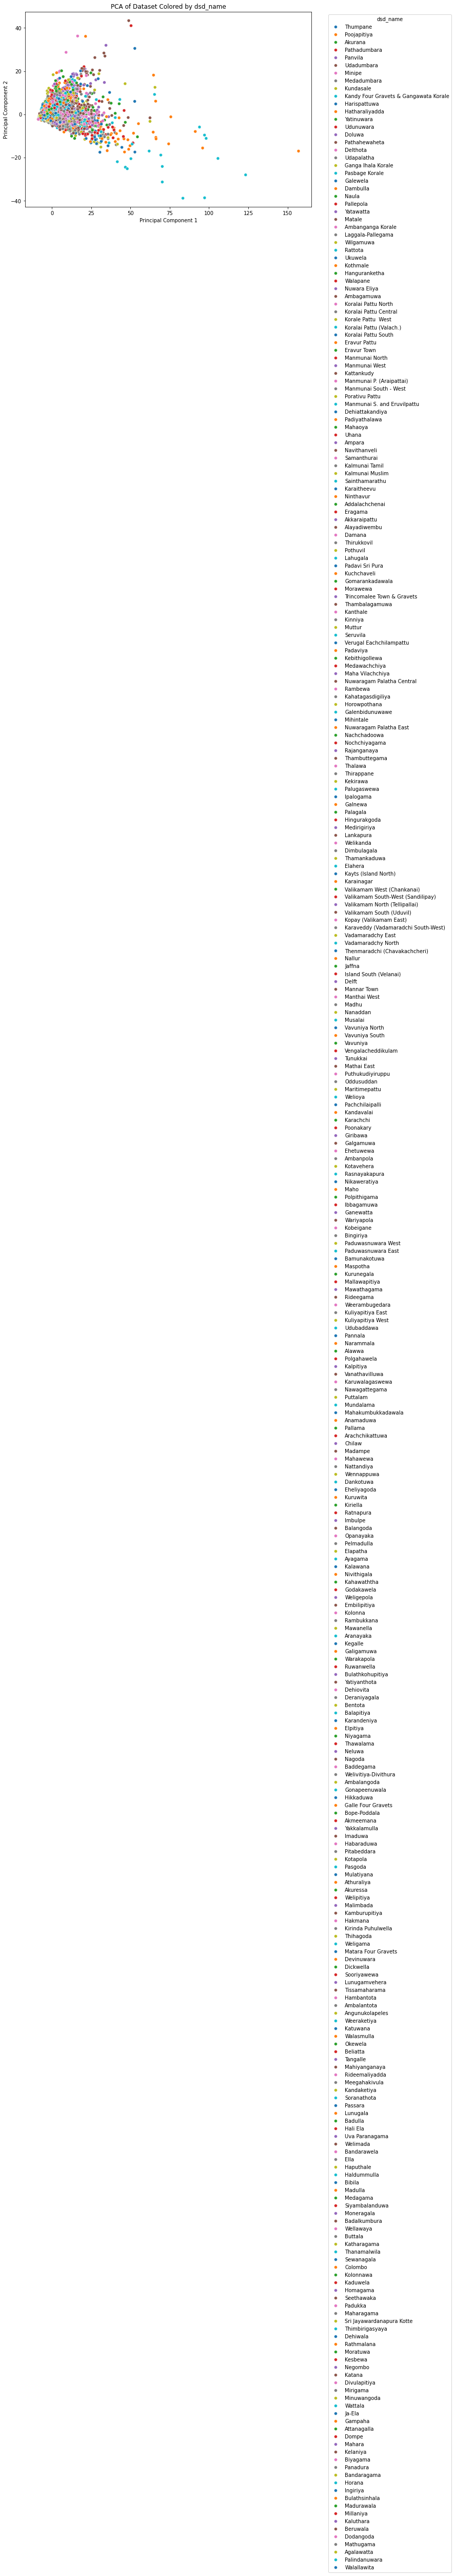

In [28]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['gnd_id'] = X.index

# Merge PCA results with labels
pca_df = pca_df.merge(y, left_on='gnd_id', right_index=True)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='dsd_name', palette='tab10')
plt.title('PCA of Dataset Colored by dsd_name')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='dsd_name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('pca_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

/home/chanuka/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f3f09079c60>
Traceback (most recent call last):
  File "/home/chanuka/.local/lib/python3.10/site-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/chanuka/.local/lib/python3.10/site-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/home/chanuka/.local/lib/python3.10/site-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  F

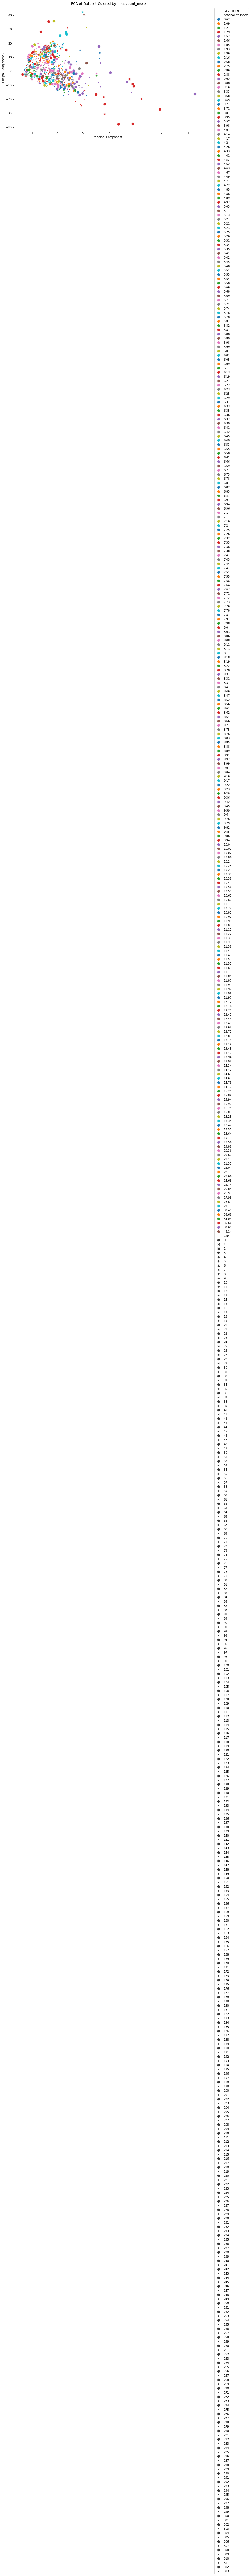

In [48]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['gnd_id'] = X.index

# Merge PCA results with labels
pca_df = pca_df.merge(y, left_on='gnd_id', right_index=True)


kmeans = KMeans(n_clusters=len(y['dsd_name'].unique()), random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='headcount_index', style='Cluster', palette='tab10', s=100)
plt.title('PCA of Dataset Colored by headcount_index')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='dsd_name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure
plt.savefig('pca_clusters_plot.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()